In [31]:
import xml.etree.ElementTree as ET

def extract_aspects_and_polarities(file_path):
    # Charger le fichier XML
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    # Liste pour stocker les aspects et leurs polarités
    aspects_with_polarities = []
    
    # Parcourir chaque phrase dans le fichier XML
    for sentence in root.findall('.//sentence'):
        sentence_id = sentence.get('id')
        for aspectTerm in sentence.findall('.//aspectTerms/aspectTerm'):
            term = aspectTerm.get('term')
            polarity = aspectTerm.get('polarity')
            aspects_with_polarities.append({
                'sentence_id': sentence_id,
                'aspect_term': term,
                'polarity': polarity
            })
            
    return aspects_with_polarities

# Chemins vers vos fichiers d'entraînement
files = [
    '../data/Restaurants_Train.xml',
    '../data/Laptop_Train.xml'
]

# Extraction et affichage des aspects et de leurs polarités pour vérification
for file_path in files:
    aspects_polarities = extract_aspects_and_polarities(file_path)
    print(f"Extraits de {file_path}:")
    for item in aspects_polarities[:5]:  # Afficher les 5 premiers pour vérification
        print(item)
    print("\n---------------------------\n")


Extraits de ../data/Restaurants_Train.xml:
{'sentence_id': '3121', 'aspect_term': 'staff', 'polarity': 'negative'}
{'sentence_id': '2777', 'aspect_term': 'food', 'polarity': 'positive'}
{'sentence_id': '1634', 'aspect_term': 'food', 'polarity': 'positive'}
{'sentence_id': '1634', 'aspect_term': 'kitchen', 'polarity': 'positive'}
{'sentence_id': '1634', 'aspect_term': 'menu', 'polarity': 'neutral'}

---------------------------

Extraits de ../data/Laptop_Train.xml:
{'sentence_id': '2339', 'aspect_term': 'cord', 'polarity': 'neutral'}
{'sentence_id': '2339', 'aspect_term': 'battery life', 'polarity': 'positive'}
{'sentence_id': '1316', 'aspect_term': 'service center', 'polarity': 'negative'}
{'sentence_id': '1316', 'aspect_term': '"sales" team', 'polarity': 'negative'}
{'sentence_id': '1316', 'aspect_term': 'tech guy', 'polarity': 'neutral'}

---------------------------


In [32]:
# Pseudo-code pour une approche à règles simple
def determine_aspect_polarity(aspect_term, sentence, lexicon, window_size=3):
    # Tokenisez la phrase
    tokens = tokenize(sentence)
    # Trouvez l'index du terme d'aspect dans la liste des tokens
    aspect_index = tokens.index(aspect_term)
    start = max(0, aspect_index - window_size)
    end = min(len(tokens), aspect_index + window_size + 1)
    # Calculez la polarité
    polarity_score = 0
    for i in range(start, end):
        word = tokens[i]
        if word in lexicon:
            polarity_score += lexicon[word]
    # Déterminez la polarité basée sur la somme
    if polarity_score > 0:
        return 'positive'
    elif polarity_score < 0:
        return 'negative'
    else:
        return 'neutral'


In [33]:
# Combinez vos données extraites en une seule liste
all_data = []
for file_path in files:
    all_data.extend(extract_aspects_and_polarities(file_path))

# Séparez les contextes et les polarités
contexts = [d['aspect_term'] for d in all_data]
polarities = [d['polarity'] for d in all_data]


In [34]:
# Model 1 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(contexts)

# Encodez les polarités en numérique
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(polarities)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = clf.predict(X_test)

# Évaluation
print(classification_report(y_test, y_pred, target_names=encoder.classes_))


              precision    recall  f1-score   support

    conflict       0.00      0.00      0.00        28
    negative       0.47      0.38      0.42       328
     neutral       0.45      0.24      0.31       225
    positive       0.62      0.82      0.71       630

    accuracy                           0.57      1211
   macro avg       0.39      0.36      0.36      1211
weighted avg       0.54      0.57      0.54      1211


In [35]:
# Test personnalisé 
test_sentence = "The battery life of this laptop is amazing but the price is too high."
# Transformer la phrase en vecteur TF-IDF
test_vector = vectorizer.transform([test_sentence])
# Prédiction avec le modèle
predicted_polarity = clf.predict(test_vector)
# Convertir le résultat numérique en polarité lisible
predicted_polarity_label = encoder.inverse_transform(predicted_polarity)
print(f"Predicted polarity: {predicted_polarity_label[0]}")


Predicted polarity: negative


In [38]:
# Optimiser le model 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Fonction pour extraire les aspects et leurs polarités
def extract_aspects_and_polarities(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    aspects_with_polarities = []
    for sentence in root.findall('.//sentence'):
        sentence_id = sentence.get('id')
        text = sentence.find('text').text  # Extraction du texte complet de la phrase pour le contexte
        for aspectTerm in sentence.findall('.//aspectTerms/aspectTerm'):
            term = aspectTerm.get('term')
            polarity = aspectTerm.get('polarity')
            aspects_with_polarities.append({
                'sentence_id': sentence_id,
                'context': text,  # Utilisation du texte complet comme contexte
                'aspect_term': term,
                'polarity': polarity
            })
    return aspects_with_polarities

# Chemins vers vos fichiers d'entraînement
files = ['../data/Restaurants_Train.xml', '../data/Laptop_Train.xml']

# Combinez vos données extraites en une seule liste
all_data = []
for file_path in files:
    all_data.extend(extract_aspects_and_polarities(file_path))

# Séparez les contextes et les polarités
contexts = [d['context'] for d in all_data]  # Utilisation du contexte complet
polarities = [d['polarity'] for d in all_data]

# Conversion des textes en format numérique
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(contexts)

# Encodez les polarités en numérique
encoder = LabelEncoder()
y = encoder.fit_transform(polarities)

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Meilleurs paramètres:", grid_search.best_params_)
clf_best = grid_search.best_estimator_


Meilleurs paramètres: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}


In [39]:
from sklearn.metrics import classification_report

y_pred = clf_best.predict(X_test)

print(classification_report(y_test, y_pred, target_names=encoder.classes_))


              precision    recall  f1-score   support

    conflict       0.20      0.07      0.11        28
    negative       0.63      0.59      0.61       328
     neutral       0.60      0.36      0.45       225
    positive       0.74      0.89      0.80       630

    accuracy                           0.69      1211
   macro avg       0.54      0.48      0.49      1211
weighted avg       0.67      0.69      0.67      1211


In [43]:
import xml.etree.ElementTree as ET

def extract_sentences_for_prediction(file_path):
    sentences = []
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    for sentence in root.findall('.//sentence'):
        text = sentence.find('text').text
        sentences.append(text)
    
    return sentences

# Charger les fichiers sans labels
test_files = [
    '../data/Laptop_Test_NoLabels.xml',
    '../data/Restaurants_Test_NoLabels.xml'
]

# Extraire les phrases des fichiers sans labels
test_sentences = []
for test_file in test_files:
    test_sentences.extend(extract_sentences_for_prediction(test_file))

# Transformer les phrases en vecteurs TF-IDF
test_vectors = vectorizer.transform(test_sentences)

# Prédire la polarité pour chaque phrase
predicted_polarities = clf.predict(test_vectors)

# Afficher les prédictions
for sentence, prediction in zip(test_sentences, predicted_polarities):
    print(f"Sentence: {sentence}\nPredicted polarity: {encoder.inverse_transform([prediction])[0]}\n")


Sentence: I liked the aluminum body.
Predicted polarity: neutral

Sentence: Lightweight and the screen is beautiful!
Predicted polarity: positive

Sentence: Buy it, love it, and I promise you won't regret it.
Predicted polarity: positive

Sentence: From the build quality to the performance, everything about it has been sub-par from what I would have expected from Apple.
Predicted polarity: negative

Sentence: pretty much everything else about the computer is good it just stops working out of no were.
Predicted polarity: neutral

Sentence: Originally bought it for my wife.
Predicted polarity: neutral

Sentence: It was truly a great computer costing less than one thousand bucks before tax.
Predicted polarity: neutral

Sentence: I bought this laptop on Saturday and am completely in love with it!
Predicted polarity: positive

Sentence: If you don't like fingerprints, this might not be the laptop for you.
Predicted polarity: positive

Sentence: Boots up fast and runs great!
Predicted polari

In [41]:
#je veux rajouter cette partie pour la visualisation des prediction 

import xml.etree.ElementTree as ET

def extract_sentences(file_path):
    # Charger le fichier XML et extraire les phrases
    tree = ET.parse(file_path)
    root = tree.getroot()
    sentences = [sentence.find('text').text for sentence in root.findall('.//sentence')]
    return sentences

# Charger les modèles et les vectoriseurs que vous avez utilisés pour l'entraînement
# Assurez-vous que vectorizer et clf ont été ajustés avec les données d'entraînement et sont accessibles ici

laptop_test_file = '../data/Laptop_Test_NoLabels.xml'
restaurant_test_file = '../data/Restaurants_Test_NoLabels.xml'

# Extraire les phrases pour chaque fichier de test
laptop_sentences = extract_sentences(laptop_test_file)
restaurant_sentences = extract_sentences(restaurant_test_file)

laptop_vectors = vectorizer.transform(laptop_sentences)
restaurant_vectors = vectorizer.transform(restaurant_sentences)

# Prédire la polarité pour chaque phrase
laptop_predicted_polarities = clf.predict(laptop_vectors)
restaurant_predicted_polarities = clf.predict(restaurant_vectors)

# Afficher les prédictions pour les laptops
print("Predictions for Laptops:")
for sentence, prediction in zip(laptop_sentences, laptop_predicted_polarities):
    print(f"Sentence: {sentence}")
    print(f"Predicted polarity: {encoder.inverse_transform([prediction])[0]}")
    print()

# Afficher les prédictions pour les restaurants
print("Predictions for Restaurants:")
for sentence, prediction in zip(restaurant_sentences, restaurant_predicted_polarities):
    print(f"Sentence: {sentence}")
    print(f"Predicted polarity: {encoder.inverse_transform([prediction])[0]}")
    print()


Predictions for Laptops:
Sentence: I liked the aluminum body.
Predicted polarity: neutral

Sentence: Lightweight and the screen is beautiful!
Predicted polarity: positive

Sentence: Buy it, love it, and I promise you won't regret it.
Predicted polarity: positive

Sentence: From the build quality to the performance, everything about it has been sub-par from what I would have expected from Apple.
Predicted polarity: negative

Sentence: pretty much everything else about the computer is good it just stops working out of no were.
Predicted polarity: neutral

Sentence: Originally bought it for my wife.
Predicted polarity: neutral

Sentence: It was truly a great computer costing less than one thousand bucks before tax.
Predicted polarity: neutral

Sentence: I bought this laptop on Saturday and am completely in love with it!
Predicted polarity: positive

Sentence: If you don't like fingerprints, this might not be the laptop for you.
Predicted polarity: positive

Sentence: Boots up fast and run

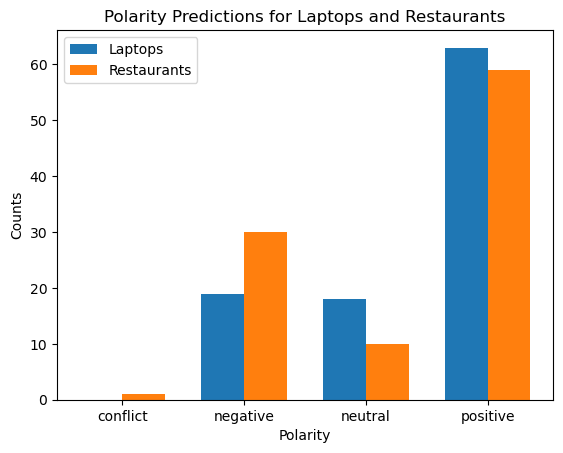

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Utilisez encoder.classes_ pour obtenir les noms des classes dans l'ordre correct
polarity_names = encoder.classes_

# Comptez le nombre de chaque polarité prédite pour les laptops et les restaurants
laptop_polarity_counts = np.bincount(laptop_predicted_polarities, minlength=len(polarity_names))
restaurant_polarity_counts = np.bincount(restaurant_predicted_polarities, minlength=len(polarity_names))

# Créez des barres pour chaque ensemble de données
bar_width = 0.35
index = np.arange(len(polarity_names))

# Créez un graphique en barres
fig, ax = plt.subplots()
bar1 = ax.bar(index, laptop_polarity_counts, bar_width, label='Laptops')
bar2 = ax.bar(index + bar_width, restaurant_polarity_counts, bar_width, label='Restaurants')

# Ajoutez des étiquettes et des titres
ax.set_xlabel('Polarity')
ax.set_ylabel('Counts')
ax.set_title('Polarity Predictions for Laptops and Restaurants')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(polarity_names)
ax.legend()

# Montrez le graphique
plt.show()


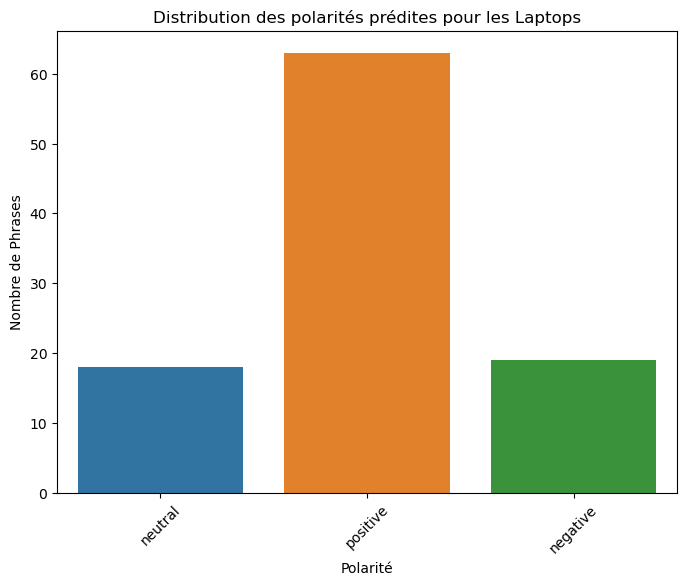

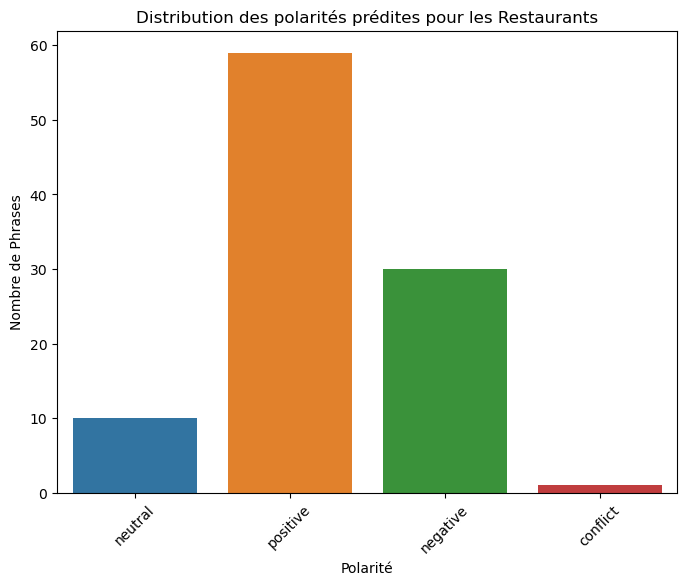

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns



laptop_polarity_labels = encoder.inverse_transform(laptop_predicted_polarities)

#Convertir  les prédictions numériques en étiquettes lisibles pour les restaurants
restaurant_polarity_labels = encoder.inverse_transform(restaurant_predicted_polarities)

#les labels sont bien des chaînes de caractères et non des numériques
assert isinstance(laptop_polarity_labels[0], str)
assert isinstance(restaurant_polarity_labels[0], str)

#Creationdes graphique  g pour les laptops
plt.figure(figsize=(8, 6))
sns.countplot(x=laptop_polarity_labels)
plt.title('Distribution des polarités prédites pour les Laptops')
plt.xlabel('Polarité')
plt.ylabel('Nombre de Phrases')
plt.xticks(rotation=45)  
plt.show()

#  pour les restaurants
plt.figure(figsize=(8, 6))
sns.countplot(x=restaurant_polarity_labels)
plt.title('Distribution des polarités prédites pour les Restaurants')
plt.xlabel('Polarité')
plt.ylabel('Nombre de Phrases')
plt.xticks(rotation=45)  # Pour une meilleure lisibilité des étiquettes sur l'axe des x
plt.show()
